In [1]:
import csv
import json
import gzip
import codecs
import pyBigWig
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from deeplift.visualization import viz_sequence
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

In [2]:
def generate_matrix(seq):
    seq_matrix = np.zeros((4, len(seq)))
    for j in range(len(seq)):
        if seq[j] == 'A':
            seq_matrix[0,j] = 1
        elif seq[j] == 'C':
            seq_matrix[1,j] = 1
        elif seq[j] == 'G':
            seq_matrix[2,j] = 1
        elif seq[j] == 'T':
            seq_matrix[3,j] = 1
    return seq_matrix
def get_PSAM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score += np.prod(diagonal)
    return score
def get_PWM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score = np.maximum(score, np.sum(diagonal))
    return score

def ddG(Kd1, Kd2, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd2/Kd1)

In [3]:
lines = []
with open('../data/experimental/PSAMs/Pho4_PSAM_extended.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
PHO4_PSAM = np.array(lines)[1:,0:].T.astype('float')
lines = []
with open('../data/experimental/PSAMs/Cbf1_PSAM_extended.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
CBF1_PSAM = np.array(lines)[1:,0:].T.astype('float')

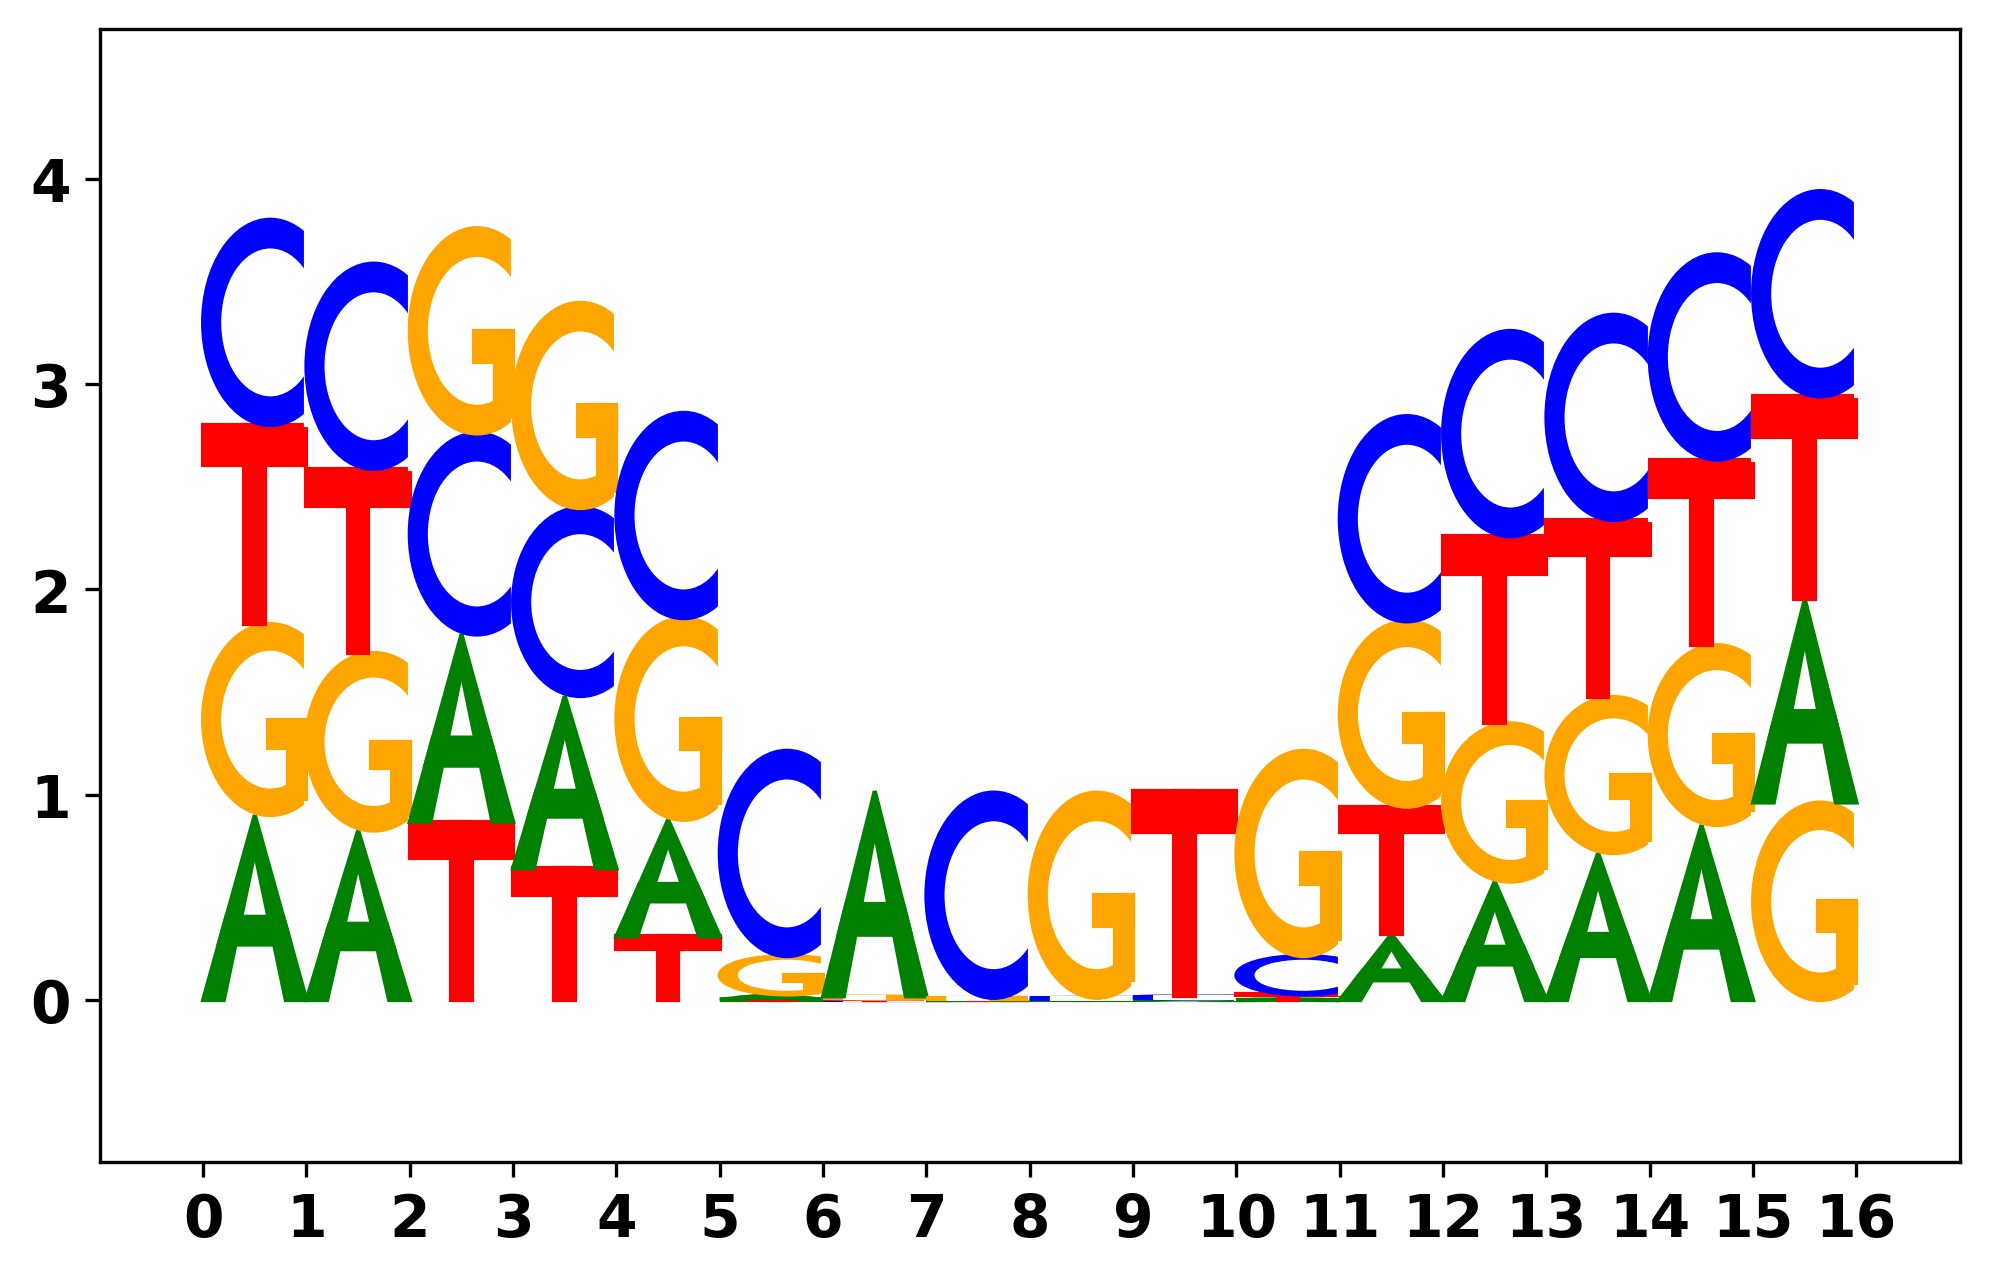

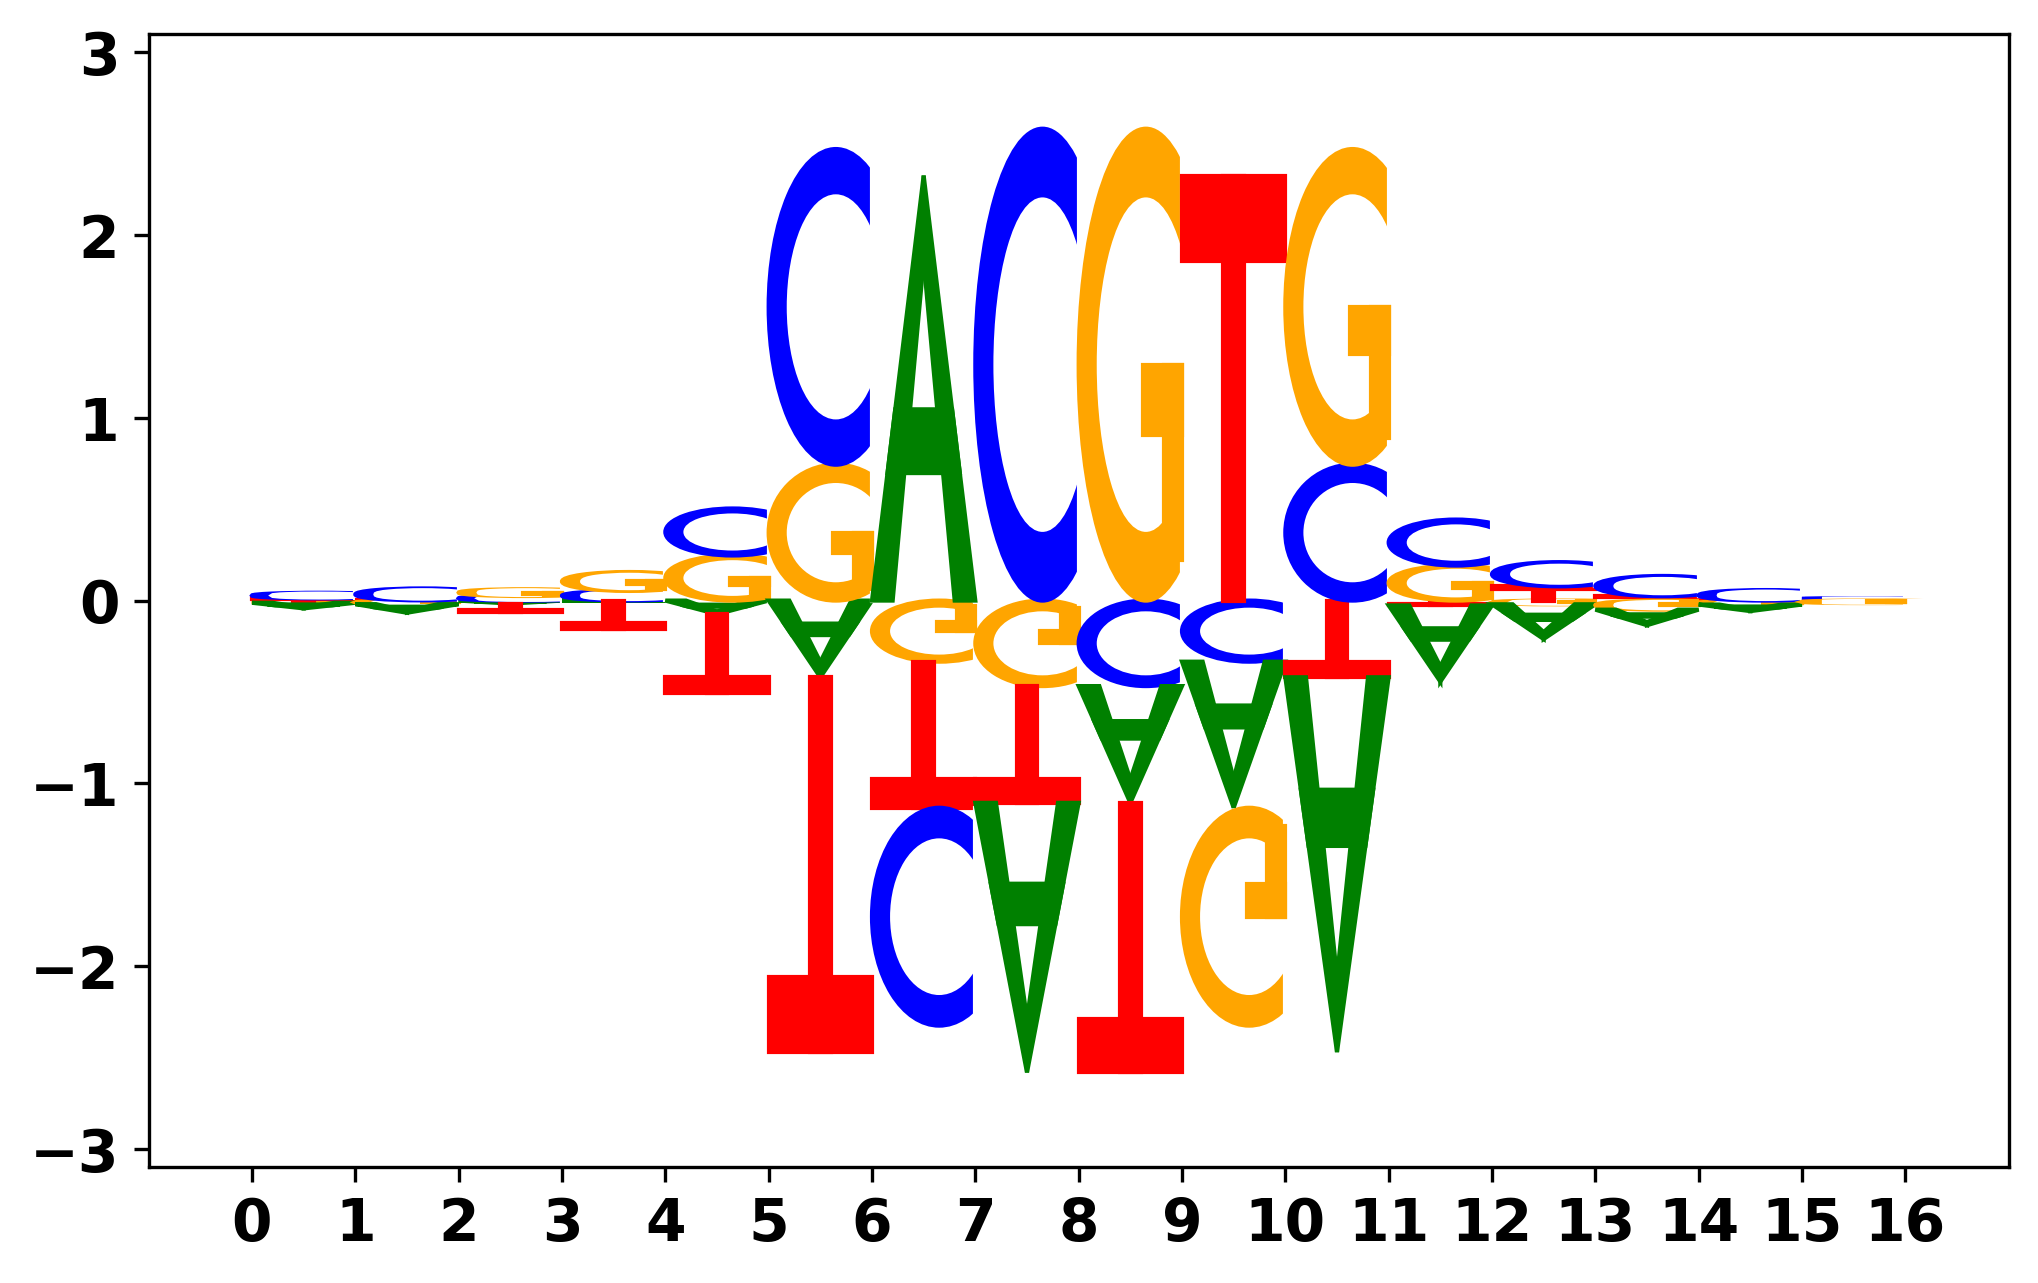

In [4]:
font = {'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_PSAM,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})
fig.savefig('PHO4_PSAM.png', dpi=300)
PHO4_ddG = [[-ddG(x,1) for x in j] for j in PHO4_PSAM]
PHO4_ddG = np.array([i-np.mean(i) for i in PHO4_ddG])
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})
fig.savefig('PHO4_DDG_matrix.png', dpi=300)

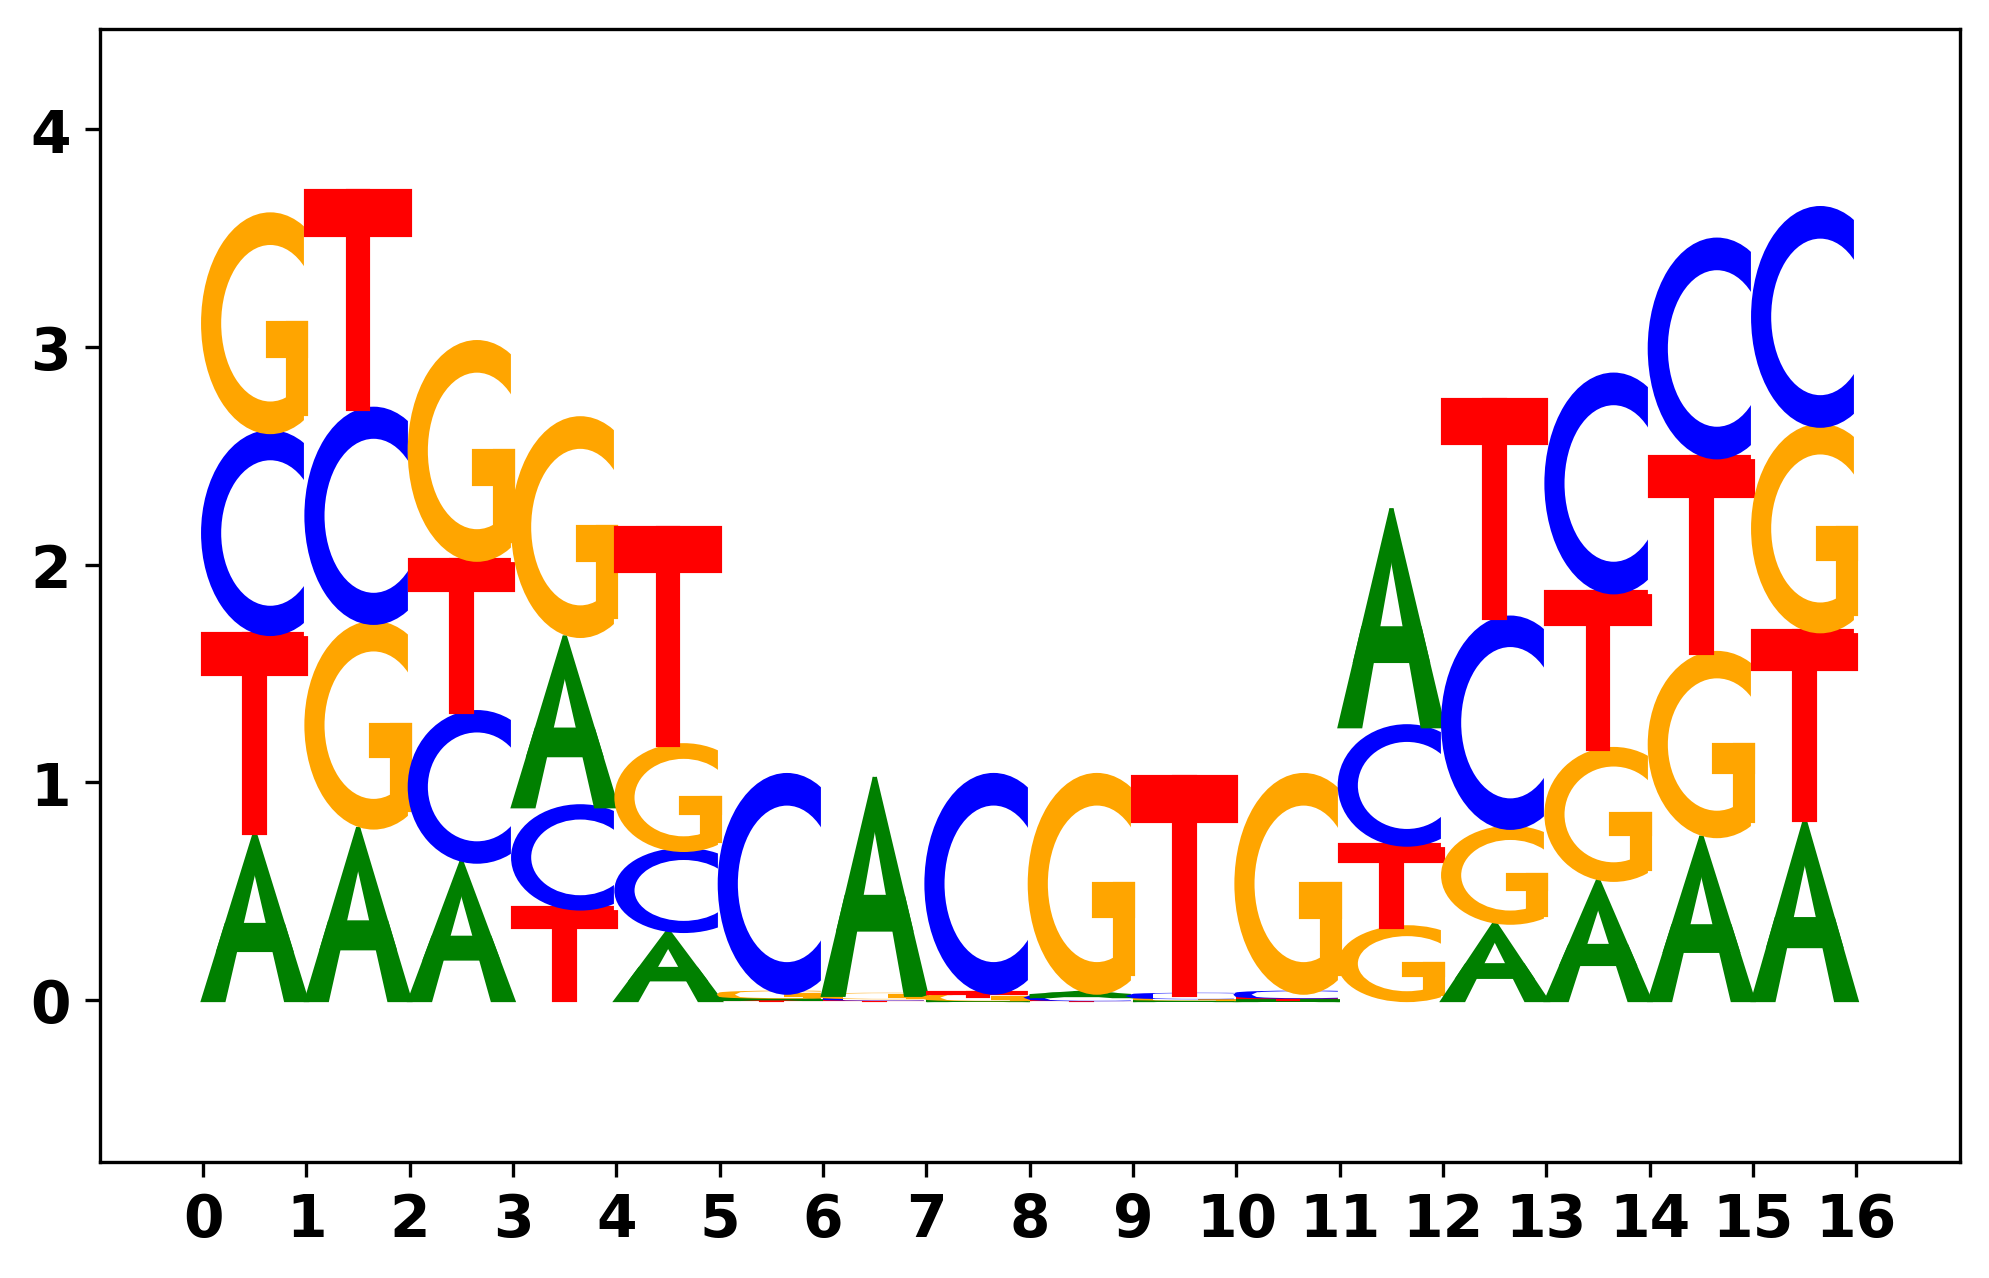

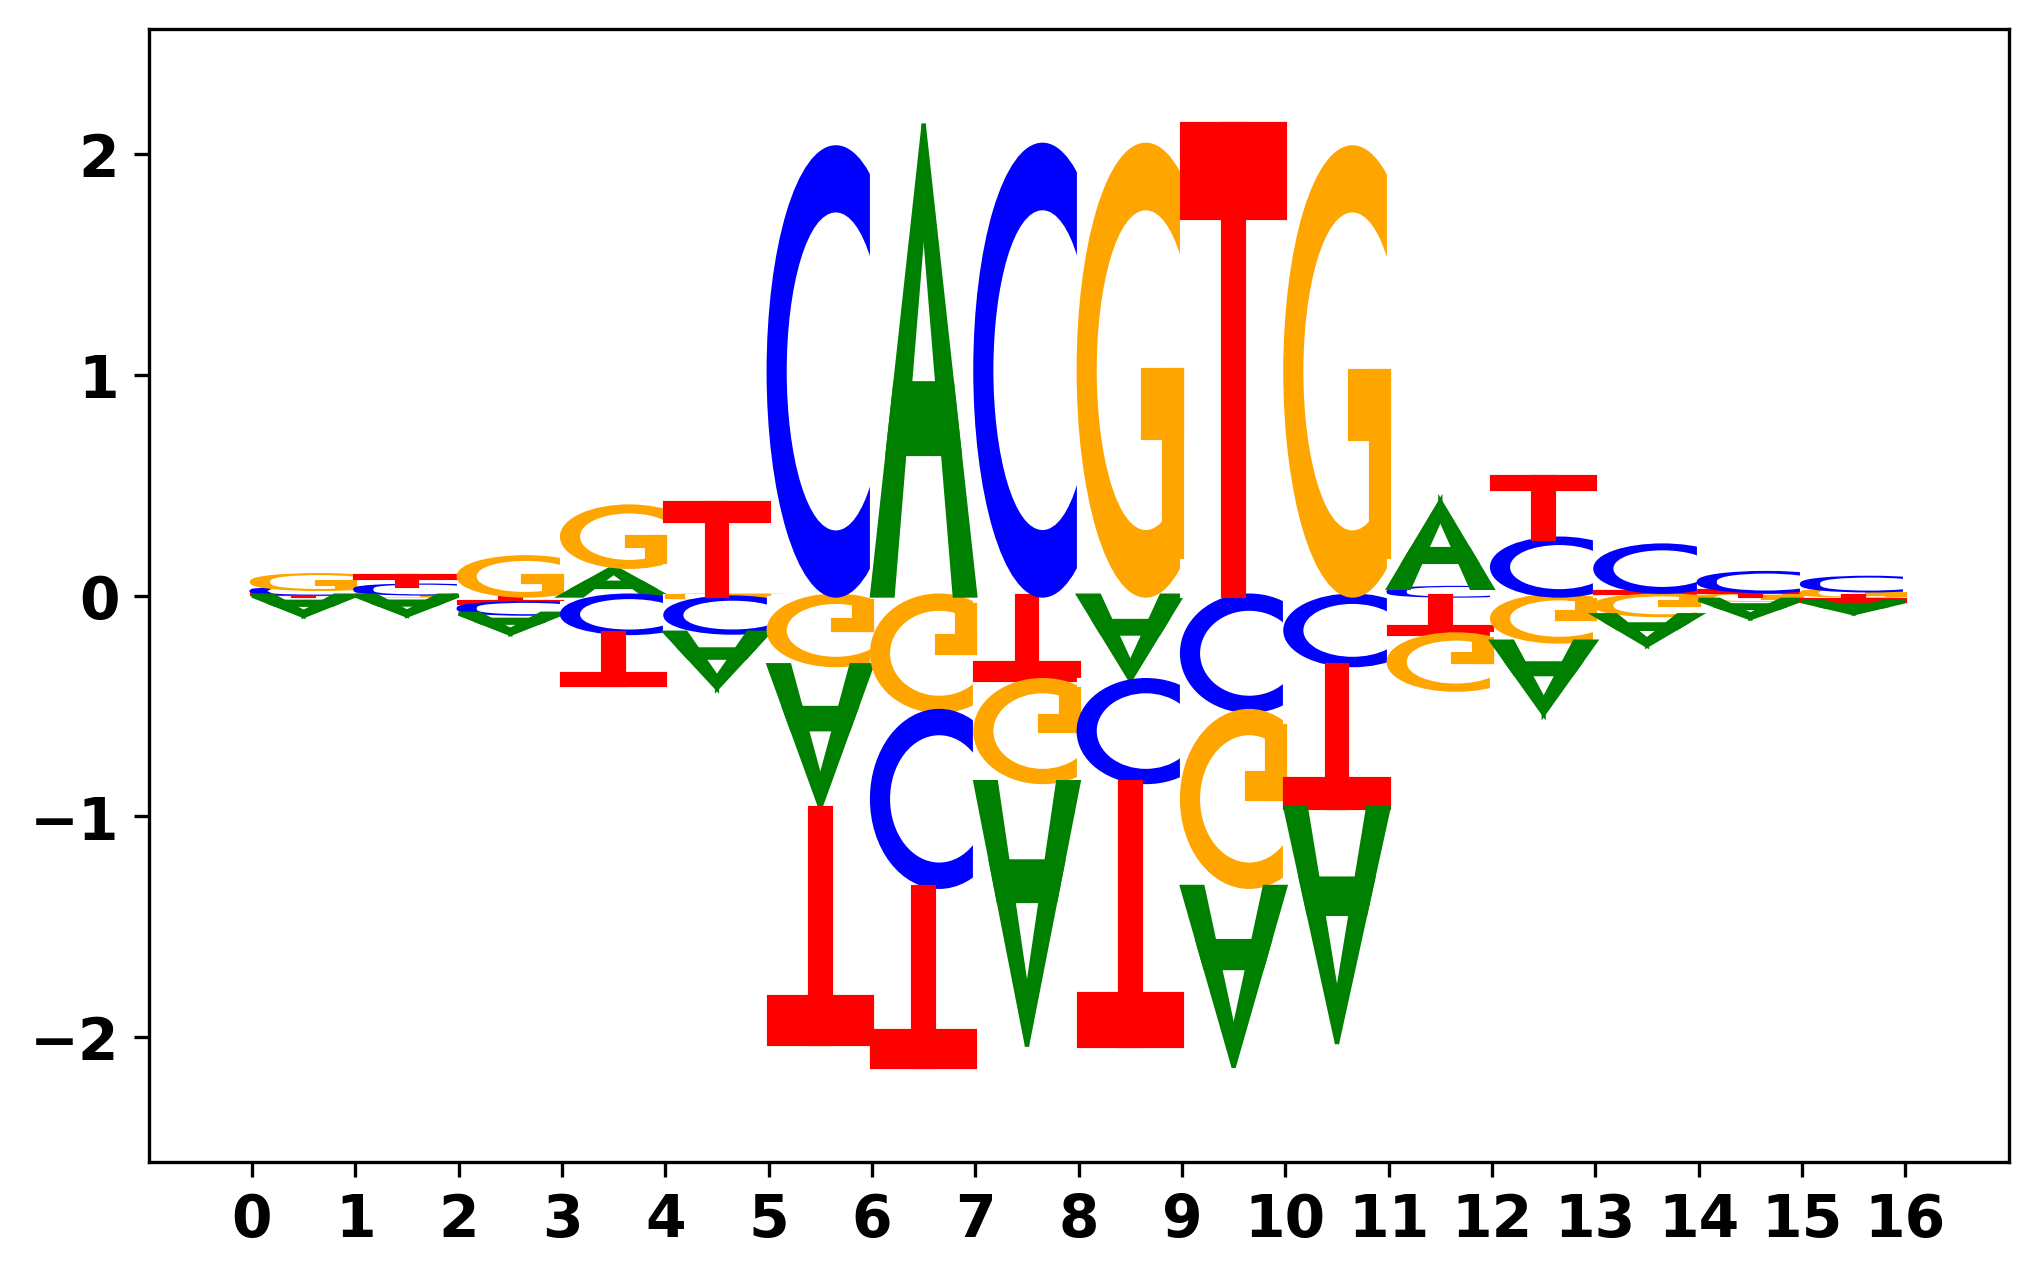

In [5]:
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, CBF1_PSAM,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})
fig.savefig('CBF1_PSAM.png', dpi=300)
CBF1_ddG = [[-ddG(x,1) for x in j] for j in CBF1_PSAM]
CBF1_ddG = np.array([i-np.mean(i) for i in CBF1_ddG])
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, CBF1_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})
fig.savefig('CBF1_DDG_matrix.png', dpi=300)

In [6]:
fastapath = "../data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [7]:
tfToBigWigs = {}
tfToBigWigs["pho4_pbexo"] = (pyBigWig.open("../data/pho4_pbexo/basename_prefix.pooled.positive.bigwig"),
                             pyBigWig.open("../data/pho4_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["cbf1_pbexo"] = (pyBigWig.open("../data/cbf1_pbexo/basename_prefix.pooled.positive.bigwig"),
                             pyBigWig.open("../data/cbf1_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["pho4_120m"] = (pyBigWig.open("../data/nexus/120min/sc_myc_PHO4_120min_nexus_1_positive.bw"),
                            pyBigWig.open("../data/nexus/120min/sc_myc_PHO4_120min_nexus_1_negative.bw"))
tfToBigWigs["cbf1_nexus"] = (pyBigWig.open("../data/cbf1_nexus/pos.bw"),
                             pyBigWig.open("../data/cbf1_nexus/neg.bw"))

In [8]:
tfToBeds = {}
tfToBeds["pho4_pbexo"] = open("../data/pho4_pbexo/100_around_summits.bed")
tfToBeds["cbf1_pbexo"] = open("../data/cbf1_pbexo/100_around_summits.bed")
tfToBeds["pho4_120m"] = open("../data/nexus/120min/100_around_summits.bed")
tfToBeds["cbf1_nexus"] = open("../data/cbf1_nexus/100_around_summits.bed")

In [9]:
R=1.9872036e-3
T=295
for key in tfToBeds:
    xvals = []
    yvals = []
    if "pho4" in key: PSAM = PHO4_PSAM
    else: PSAM = CBF1_PSAM
    for line in tfToBeds[key]:
        chrm, ss, es = line.strip().split('\t')
        start = int(ss)
        end = int(es)
        posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
        where_are_NaNs = np.isnan(posvals)
        posvals[where_are_NaNs] = 0.0
        negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
        where_are_NaNs = np.isnan(negvals)
        negvals[where_are_NaNs] = 0.0
        yvals.append(1+np.sum(np.abs(posvals)+np.abs(negvals)))
        xvals.append(-R*T*np.log(get_PSAM_score(GenomeDict[chrm][start:end].upper(), PSAM)))
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(111)
    plt.scatter(xvals, yvals, alpha=0.35)
    meta = {}
    meta["key"] = key
    meta["x-axis"] = "-R*T*log ( PSAM score )"
    meta["y-axis"] = "natural log of ( 1 + counts )"
    meta["Number of points"] = len(xvals)
    meta["spearman"] = spearmanr(xvals, yvals)[0]
    meta["pearson"] = pearsonr(xvals, yvals)[0]
    # Residuals is sum of squared residuals of the least-squares fit
    meta["residuals"] = np.polyfit(xvals, yvals, 1, full=True)[1][0]
    # ax.set_xlim((1,5.75))
    # ax.set_ylim((1,5.75))
    # ax.set_aspect('equal')
    fig.savefig(key+'_PSAM_baseline.png', dpi=300)
    plt.clf()
    with open(key+'_PSAM_metadata.json', 'w') as fp: json.dump(meta, fp)

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>